In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [15]:
quantative = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
quantative.remove('Id')
quantative.remove('SalePrice')

In [16]:
qualitative = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

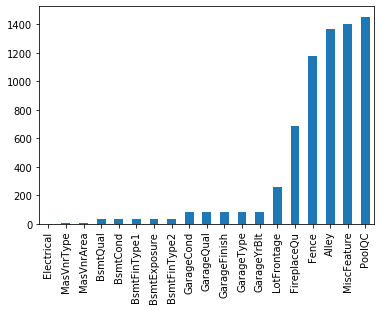

In [17]:
missing = train_df.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

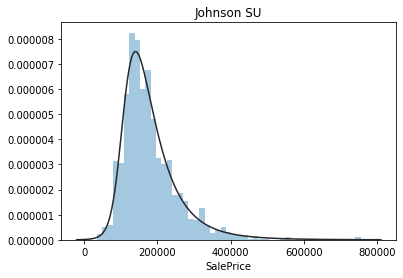

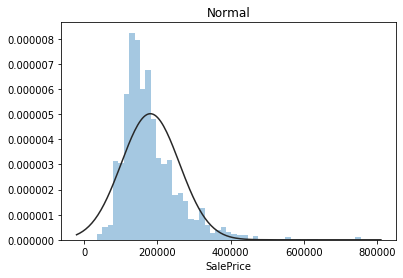

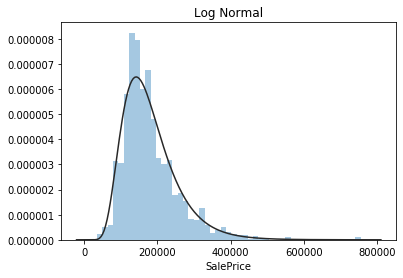

In [19]:
y = train_df['SalePrice']
plt.figure(1),plt.title('Johnson SU')
sns.distplot(y,kde=False,fit=stats.johnsonsu)
plt.figure(2),plt.title('Normal')
sns.distplot(y,kde=False,fit=stats.norm)
plt.figure(3),plt.title('Log Normal')
sns.distplot(y,kde=False,fit=stats.lognorm)

In [22]:
test_normality = lambda x:stats.shapiro(x.fillna(0))[1]<0.01
normal = pd.DataFrame(train_df[quantative])
normal = normal.apply(test_normality)
print(not normal.any())

False


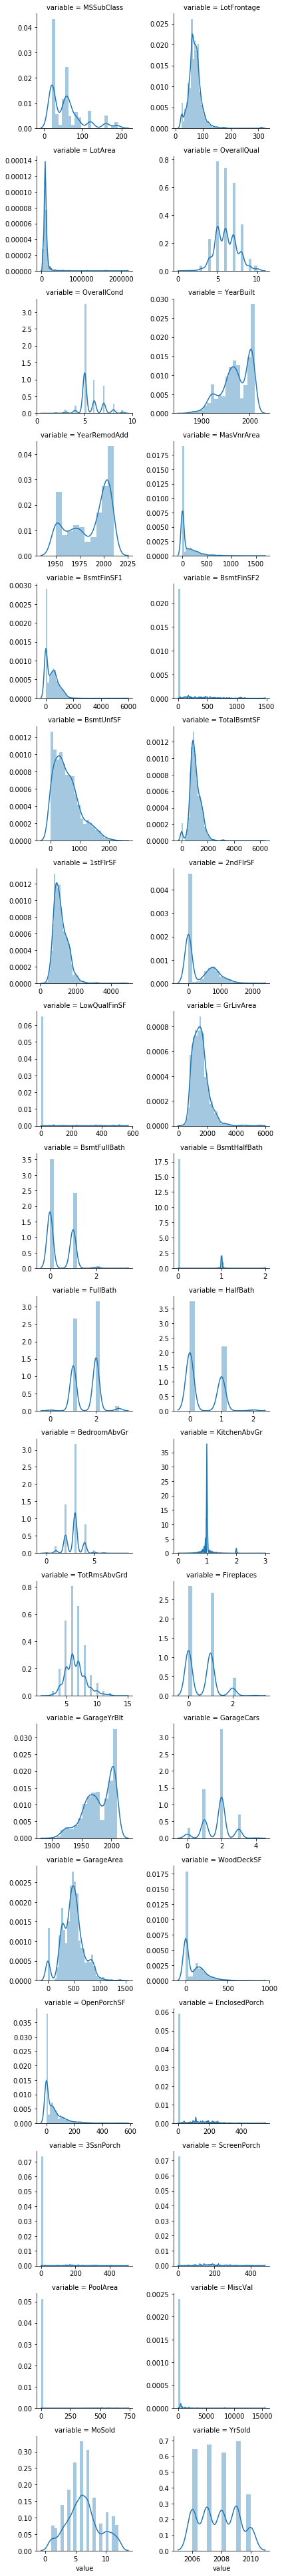

In [24]:
f = pd.melt(train_df,value_vars=quantative)
g = sns.FacetGrid(f, col='variable',col_wrap=2 , sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [27]:
for c in qualitative:
    train_df[c] = train_df[c].astype('category')
    if train_df[c].isnull().any():
        train_df[c] = train_df[c].cat.add_categories(['Missing'])
        train_df[c].fillna('Missing',inplace=True)

In [29]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=90)

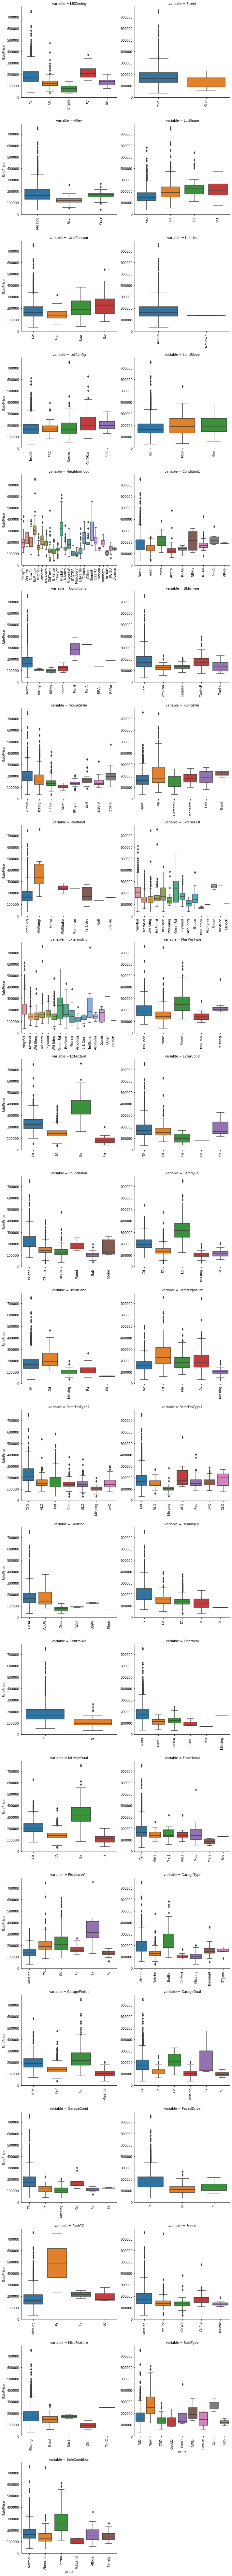

In [30]:
f = pd.melt(train_df,id_vars=['SalePrice'],value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

In [44]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c]==cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

In [45]:
a = anova(train_df)

In [46]:
a['disparity'] = np.log(1/a['pval'].values)

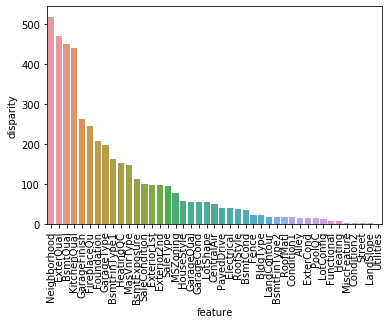

In [47]:
sns.barplot(data=a, x='feature', y = 'disparity')
x = plt.xticks(rotation=90)

In [49]:
def encode(frame,feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train_df, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


# Correlation

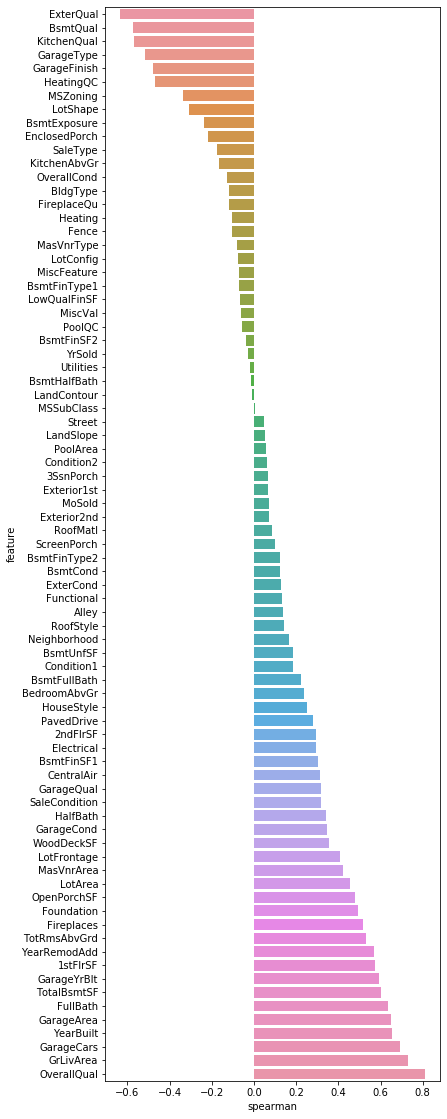

In [50]:
def spearman(frame,features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'],'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr,y='feature', x = 'spearman', orient='h')
    
features = qualitative + quantative
spearman(train_df,features)

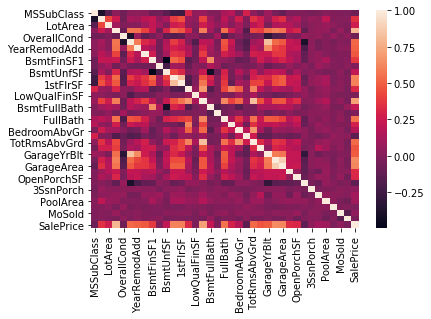

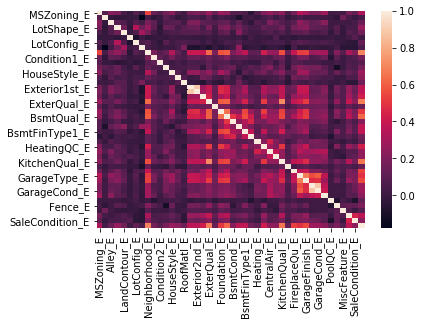

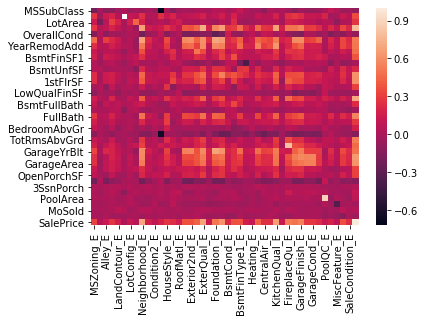

In [52]:
plt.figure(1)
corr = train_df[quantative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train_df[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantative)+1, len(qual_encoded)+1]),index=quantative+['SalePrice'],
                   columns=qual_encoded+['SalePrice'])
for q1 in quantative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1,q2] = train_df[q1].corr(train_df[q2])
sns.heatmap(corr)

# Pairplot

In [58]:
def pairplot(x,y,**kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time':x,'value':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

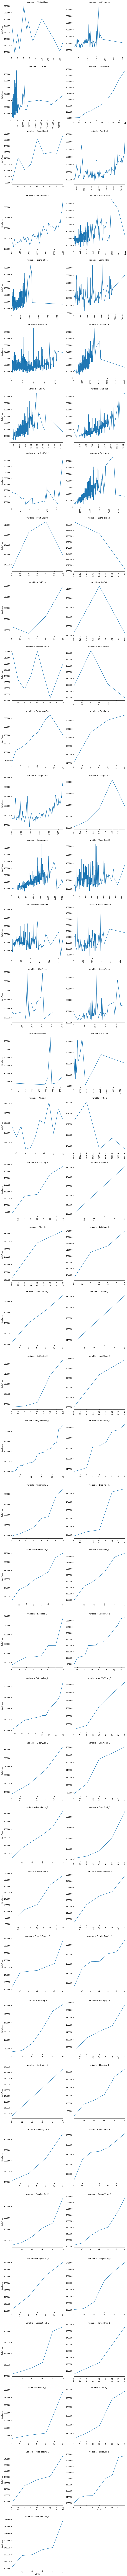

In [59]:
f = pd.melt(train_df, id_vars=['SalePrice'], value_vars=quantative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

# Price Segement

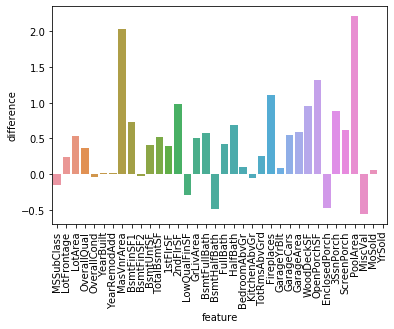

In [61]:
features = quantative

standard = train_df[train_df['SalePrice'] < 200000]
pricey = train_df[train_df['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

# Clustering

0.7498467948255345


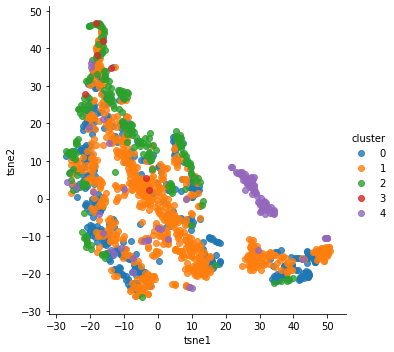

In [63]:
features = quantative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_df[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

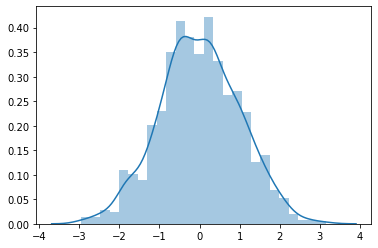

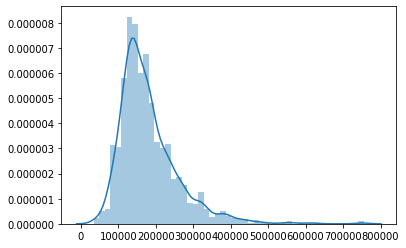

In [65]:
y = train_df['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)